# Baechi Full

In [53]:
import torch
import torchvision
from torchvision import models
import time
import networkx as nx
from torch import optim, nn
from importlib import reload
import numpy as np
import pickle

import GPUtil

import sys


## Copy of Inceptionv3, slightly modified for recording intermeridates
sys.path.append('/home/cshetty2/sct/pytorch')
import reformated_models.inception_modified as inception_modified

## Modified Alexnet, with a'factor' by which it can be made 'fat' 
import simple_model as sm
import baechiTest_dummyModels as dm

######## For profiler (some experiments. Not required) #################
from torch.profiler import profile, record_function, ProfilerActivity


## Placer libs of baechi
sys.path.append('/home/cshetty2/sct')
from placer.placer_lib import *

import matplotlib.pyplot as plt

######## For debug purposes ONLY ########
import ctypes, gc
import psutil, os

### From https://discuss.pytorch.org/t/how-pytorch-releases-variable-garbage/7277
def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())
    
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)
#########################################

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
from baechi_units_old import *

In [55]:
##### Change this settings in bbaechi_units.py file
# itype       = 'forward'  # help: forward/all -> Conside forward path only or both
# prof_rounds = 40      # help: 'rounds for profiler'
# prof_gpu_id = 3      # help: 'which gpu to place the profiler'
# batch_size  = '128'   # help: 'batch_size'
# gpu_num     = 3      # help: 'number of gpu to use'
# sch         = 'sct'  # help: 'sct/etf/topo'

# args = Args(itype, prof_rounds, prof_gpu_id, batch_size, gpu_num, sch)

In [56]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 1.96911621 GB
Cached:    1.9921875 GB
-----------
GPU: 2
Memory Usage:
Allocated: 1.26580811 GB
Cached:    1.2890625 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    1.92382812 GB
-----------


# Settings of the experiment

In [57]:
model_name = "ParallelThreeLayer"
Nrun = 50 
fct = 6
run_type = "forward" 
#run_type = "training"
repetable = 1

In [58]:
if model_name == "toyToyModel":
    model = sm.toyToyModel(factor=fct)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "linearModel":
    model = sm.linearModel(factor=fct)
    inp_size_single = (1, 10000)
    opt_size = 1000

if model_name == "parallelToyModel":
    model = sm.parallelToyModel(factor=fct)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "toyModel":
    model = sm.toyModel(factor=fct)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "inception_v3":
    model = inception_modified.inception_v3(pretrained=True)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "TallParallelModel":
    factor = fct
    inp_size_single = (1, 512*factor)
    model = dm.tallParallelModel(factor, repetable)
    opt_size = 1000

    
if model_name == "ParallelTwoLayer":
    factor = fct
    inp_size_single = (1, int(512*factor))
    model = dm.parallelTwoLayer(factor, repetable)
    opt_size = 512*fct
    
if model_name == "ParallelThreeLayer":
    factor = fct
    inp_size_single = (1, int(512*factor))
    model = dm.parallelThreeLayer(factor, repetable)
    opt_size = 512*fct
    
if model_name == "ParallelThreeLayerOld":
    factor = fct
    inp_size_single = (1, int(512*factor))
    model = dm.parallelThreeLayerOld(factor)
    opt_size = 512*fct
    

In [59]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 1.96911621 GB
Cached:    1.9921875 GB
-----------
GPU: 2
Memory Usage:
Allocated: 1.26580811 GB
Cached:    1.2890625 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    1.92382812 GB
-----------


## Single GPU Run

In [60]:
single_run_gpu = 3
inp_size = (int(args.batch_size),) + inp_size_single
model = model.to(single_run_gpu)

In [61]:
if run_type == "forward":
    times = []
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
        for _ in range(Nrun):
            torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
            if repetable == 1:
                inp   = torch.ones(inp_size)
            else:
                inp   = torch.rand(inp_size)
            start = time.time()
            inp = inp.to(single_run_gpu)
            output = model(inp)
            torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
            end = time.time()
            #torch.cuda.empty_cache() #important to have this. Else output may seem correct inspite of timing mismatches
            #print_mem(args.prof_gpu_id)
            times.append(1000*(end-start))
    prof.export_chrome_trace("trace_singlegpu.json")
    single_gpu_time = np.mean(times[10:])
    print("Mean time taken:", single_gpu_time)
    print()


Mean time taken: 3.912001848220825



In [62]:
if run_type == "training":

    optimizer = optim.SGD(model.parameters(), lr = 0.0001); 
    criterion = nn.MSELoss()
    dataset = torchvision.datasets.FakeData(
        size= args.prof_rounds * int(args.batch_size),
        image_size=inp_size_single,
        num_classes=opt_size,
        transform=torchvision.transforms.ToTensor())
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=int(args.batch_size))
    result = []


    times = []
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
        for batch_idx, (inp, oup) in enumerate(data_loader):
            torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            labels = torch.randn(opt_size).to(single_run_gpu)
            start = time.time()
            inp = inp.to(single_run_gpu); 
            optimizer.zero_grad()
            output = model(inp)
            #torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            ######################### loss compute ################################################
            loss = criterion(output, labels )
            ##################################################################################
            loss.backward(loss)
            optimizer.step()
            torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            end = time.time()
            times.append(1000*(end-start))
    prof.export_chrome_trace("trace_singlegpu.json")
    single_gpu_time = np.mean(times[10:])
    print("Mean time taken:", single_gpu_time)
    print()


In [63]:
print(output)

tensor([[93312., 93312., 93312.,  ..., 93312., 93312., 93312.],
        [93312., 93312., 93312.,  ..., 93312., 93312., 93312.],
        [93312., 93312., 93312.,  ..., 93312., 93312., 93312.],
        ...,
        [93312., 93312., 93312.,  ..., 93312., 93312., 93312.],
        [93312., 93312., 93312.,  ..., 93312., 93312., 93312.],
        [93312., 93312., 93312.,  ..., 93312., 93312., 93312.]],
       device='cuda:3', grad_fn=<AddmmBackward>)


In [64]:

print_gpu_memory()
del model
del inp
del output
try:
    del labels
    del optimizer
    del loss
except: pass
gc.collect()
torch.cuda.empty_cache()
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 1.96911621 GB
Cached:    1.9921875 GB
-----------
GPU: 2
Memory Usage:
Allocated: 1.26580811 GB
Cached:    1.2890625 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.81349182 GB
Cached:    1.92578125 GB
-----------
GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 1.96911621 GB
Cached:    1.97070312 GB
-----------
GPU: 2
Memory Usage:
Allocated: 1.26580811 GB
Cached:    1.26757812 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


## Baechi Run

In [65]:
if model_name == "toyToyModel":
    model = sm.toyToyModel(factor=fct)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "linearModel":
    model = sm.linearModel(factor=fct)
    inp_size_single = (1, 10000)
    opt_size = 1000

if model_name == "parallelToyModel":
    model = sm.parallelToyModel(factor=fct)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "toyModel":
    model = sm.toyModel(factor=fct)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "inception_v3":
    model = inception_modified.inception_v3(pretrained=True)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "TallParallelModel":
    factor = fct
    inp_size_single = (1, 512*factor)
    model = dm.tallParallelModel(factor, repetable)
    opt_size = 1000

    
if model_name == "ParallelTwoLayer":
    factor = fct
    inp_size_single = (1, int(512*factor))
    model = dm.parallelTwoLayer(factor, repetable)
    opt_size = 512*fct
    
if model_name == "ParallelThreeLayer":
    factor = fct
    inp_size_single = (1, int(512*factor))
    model = dm.parallelThreeLayer(factor, repetable)
    opt_size = 512*fct
    
if model_name == "ParallelThreeLayerOld":
    factor = fct
    inp_size_single = (1, int(512*factor))
    model = dm.parallelThreeLayerOld(factor)
    opt_size = 512*fct
    

In [66]:
inp_size = inp_size_single

In [67]:
return_graph, tester = build_graph(model, args.prof_gpu_id, args.prof_rounds, inp_size = inp_size)
#available_devices = range(args.gpu_num)
available_devices = [1,2]
available_device_list = {k:device_list[k] for k in available_devices}
DEVICE_GRAPH_MULTIPLE = create_device_graph(available_device_list)

Profiling started ********************
--> Module name:  _squeezeLayer()
--> Module name:  Linear(in_features=3072, out_features=12288, bias=True)
--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  Linear(in_features=12288, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
--> Module name:  _concatenateLayer()
--> Module name:  Linear(in_features=9216, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)
make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7fdfe06d1198>
Dealing with this variable: <AddmmBackward object at 0x7fdfb81aaa90>
Dealing with this variable: <CatBackward object at 0

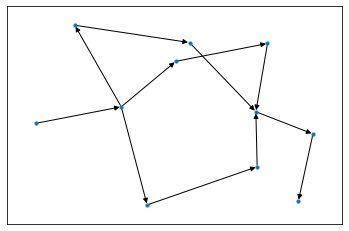

In [68]:
nx.draw_networkx(return_graph, node_size=10, font_size=1)

In [69]:
placed_op_graph = m_sct(return_graph, DEVICE_GRAPH_MULTIPLE)
copy_p(return_graph, tester)

2021-11-11 17:44:07,380 - m_sct_v1:157 - INFO - Start LP solver.


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 78              
  Cones                  : 0               
  Scalar variables       : 24              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 5
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization 

2021-11-11 17:44:07,438 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 3.439695
2021-11-11 17:44:07,439 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-11 17:44:07,440 - m_sct:143 - INFO - # favorite child: 7
2021-11-11 17:44:07,440 - m_sct:144 - INFO - # favorite child changes: 0
2021-11-11 17:44:07,445 - m_sct:172 - INFO - SCT estimated runtime: 0.000004


In [70]:
first_gpu = -1
for node_id in tester.sub_module_nodes:
    print(tester.sub_module_nodes[node_id].module)
    curr_gpu_id = tester.sub_module_nodes[node_id].p
    print(curr_gpu_id)
    if first_gpu < 0:
        first_gpu = curr_gpu_id
    print()
final_gpu = curr_gpu_id

_squeezeLayer()
1

Linear(in_features=3072, out_features=12288, bias=True)
1

Linear(in_features=12288, out_features=3072, bias=True)
1

Linear(in_features=3072, out_features=3072, bias=True)
1

Linear(in_features=12288, out_features=3072, bias=True)
2

Linear(in_features=3072, out_features=3072, bias=True)
2

Linear(in_features=12288, out_features=3072, bias=True)
1

Linear(in_features=3072, out_features=3072, bias=True)
1

_concatenateLayer()
2

Linear(in_features=9216, out_features=3072, bias=True)
2

Linear(in_features=3072, out_features=3072, bias=True)
2



In [71]:
Assign(tester)
#tester.model = tester.model.to(0)

Module:               _squeezeLayer()
GPU:                  1
Memory change:        0
Layer size:           0
Net memory occupied:  2114322432
**************************************************
Module:               Linear(in_features=3072, out_features=12288, bias=True)
GPU:                  1
Memory change:        302088192
Layer size:           151044096
Net memory occupied:  2416410624
**************************************************
Module:               Linear(in_features=12288, out_features=3072, bias=True)
GPU:                  1
Memory change:        302014464
Layer size:           151007232
Net memory occupied:  2718425088
**************************************************
Module:               Linear(in_features=3072, out_features=3072, bias=True)
GPU:                  1
Memory change:        75522048
Layer size:           37761024
Net memory occupied:  2793947136
**************************************************
Module:               Linear(in_features=12288, out_feature

In [72]:
inp_size = (int(args.batch_size),) + inp_size_single
inp_size

(32, 1, 3072)

In [73]:
if run_type == "forward":
    times = []
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof1:
        for _ in range(Nrun):
            torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
            if repetable == 1:
                inp   = torch.ones(inp_size)
            else:
                inp   = torch.rand(inp_size)
            start = time.time()
            #with torch.no_grad():
            inp = inp.to(first_gpu)  ### Code works even without this
                                            ### However, not having this gives a time penalty
                                            ### of ~6%
            output = tester.model(inp)
            torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
            end = time.time()
            #torch.cuda.empty_cache() #important to have this. Else output may seem correct inspite of timing mismatches
            #print_mem(args.prof_gpu_id)
            times.append(1000*(end-start))
    prof1.export_chrome_trace("trace_baechi.json")

    baechi_time = np.mean(times[10:])
    print("Mean time taken:", baechi_time)
    print()

Mean time taken: 3.7340283393859863



In [74]:
if run_type == "training":

    optimizer = optim.SGD(model.parameters(), lr = 0.0001); 
    criterion = nn.MSELoss()
    dataset = torchvision.datasets.FakeData(
        size= args.prof_rounds * int(args.batch_size),
        image_size=inp_size_single,
        num_classes=opt_size,
        transform=torchvision.transforms.ToTensor())
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=int(args.batch_size))


    times = []
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof1:
        for batch_idx, (inp, oup) in enumerate(data_loader):
            torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            labels = torch.randn(opt_size).to(final_gpu)
            start = time.time()
            inp = inp.to(first_gpu); 
            optimizer.zero_grad()
            output = tester.model(inp)
            #torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            ######################### loss compute ################################################
            loss = criterion(output, labels )
            ##################################################################################
            loss.backward(loss)
            optimizer.step()
            torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            end = time.time()
            torch.cuda.empty_cache() #important to have this. Else output may seem correct inspite of timing mismatches
            times.append(1000*(end-start))
    prof1.export_chrome_trace("trace_baechi.json")

    baechi_time = np.mean(times[10:])
    print("Mean time taken:", baechi_time)
    print()


In [75]:
print(output)

tensor([[93312., 93312., 93312.,  ..., 93312., 93312., 93312.],
        [93312., 93312., 93312.,  ..., 93312., 93312., 93312.],
        [93312., 93312., 93312.,  ..., 93312., 93312., 93312.],
        ...,
        [93312., 93312., 93312.,  ..., 93312., 93312., 93312.],
        [93312., 93312., 93312.,  ..., 93312., 93312., 93312.],
        [93312., 93312., 93312.,  ..., 93312., 93312., 93312.]],
       device='cuda:2', grad_fn=<AddmmBackward>)


In [76]:
print_gpu_memory()
del model
del inp
del output
try:
    del labels
    del optimizer
    del loss
except: pass
gc.collect()
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 2.95623779 GB
Cached:    2.9765625 GB
-----------
GPU: 2
Memory Usage:
Allocated: 1.90237427 GB
Cached:    1.921875 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    1.92382812 GB
-----------
GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 2.95367432 GB
Cached:    2.9765625 GB
-----------
GPU: 2
Memory Usage:
Allocated: 1.89871216 GB
Cached:    1.921875 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    1.92382812 GB
-----------


In [77]:
print("Run Type:", run_type)
print("Single GPU Mean execution time (ms): ", single_gpu_time)
print("Baechi Execution Time (ms): ",baechi_time)

Run Type: forward
Single GPU Mean execution time (ms):  3.912001848220825
Baechi Execution Time (ms):  3.7340283393859863
